In [110]:
import math
import unittest
import warnings
import abc          
import numpy as np
import sys


class Distribution(object):
    
    __metaclass__ = abc.ABCMeta
    
    def __init__(self):
        object.__init__(self)
        
    @abc.abstractmethod
    def pdf(self, value):
        return
    
    

class Gaussian(Distribution):
    
    def __init__(self, means, covariance):
        Distribution.__init__(self)
        self._mean = means
        self._variance = covariance
        
    @property
    def mean(self):
        return self._mean
    
    @property
    def variance(self):
        return self._variance
    
    
    def pdf(self, value):
        
        var = self.variance
        (numberOfFeatures, cols) = var.shape
        
        minVal = sys.float_info[3]
        for row in xrange(numberOfFeatures):
            for col in range(row, numberOfFeatures):
                if var[row, col] <= minVal:
                    var[row, col] = minVal
                    var[col, row] = minVal
        
        det = np.linalg.det(var)
        assert det > 0, "Covariance matrix is not positive definite : {0}, {1}, {2}".format(var, self.mean, value)
        
        xm = value - self.mean # 1 X F
        xmt = xm.transpose() # F X 1
        sinv = np.linalg.inv(var) # F X F
        z2 = xm*sinv*xmt # (1 X F) * (F X F) * (F X 1) = 1 X 1
        return 1.0/(np.sqrt(det) * math.pow(2*math.pi, numberOfFeatures/2.0)) * math.exp(-0.5 * z2)
    
    def __str__(self):
        return """
Mean: \n{0}
Variance: \n{1}
        """.format(pd.DataFrame(self._mean), pd.DataFrame(self._variance))
    
    def __ref__(self):
        return self.__str__()
    
        
class MixtureModel(Distribution):
    
    def __init__(self, distributions, mixin):
        Distribution.__init__(self)
        self._distributions = distributions
        self._mixin = mixin
    
    def pdf(self, point):
        return sum(self.pdfComponents(point))
    
    def pdfComponents(self, point):
        components = []
        for distribution, mixin in zip(self._distributions, self._mixin):
            components.append(distribution.pdf(point) * mixin)
        return components
    
    @property
    def distributions(self):
        return self._distributions
    
    @property
    def mixingCoefficients(self):
        return self._mixin
    

    def __str__(self):
        str = "Mixing Coefficients: {0}".format(self.mixingCoefficients)
        for idx, distribution in enumerate(self.distributions):
            str += """
Distribution {0}:
--------------------
{1}
            """.format(idx, distribution)
        
        return str
    
    def __ref__(self):
        return self.__str__()
    
    


In [111]:
import random 
import pandas as pd
import numpy as np

from ipywidgets import FloatProgress
from IPython.display import display
from collections import defaultdict

class Estimator(object):
    
    __metaclass__ = abc.ABCMeta
    
    def __init__(self):
        object.__init__(self)
        self._cnt = 0.0
        
    @abc.abstractmethod
    def add(self, value, weight=1.0):
        return
    
    @abc.abstractmethod
    def distribution(self):
        return
    
    @property
    def count(self):
        return self._cnt    
    

    
class GaussianEstimator(Estimator):

    def __init__(self):        
        Estimator.__init__(self)
        
        self.__totalWeight = 0.0
        self.__moment = 0.0
        self.__mean = None
        self.__variance = None
        
        
    
    def add(self, value, weight=1.0):
        
        if self.count == 0:
            self.__totalWeight = weight
            self.__mean = np.matrix.copy(value)
            self.__moment = np.matrix(np.zeros((self.__mean.shape[1],self.__mean.shape[1])))
        else:
            delta = value - self.__mean # (1 X F)
            temp = self.__totalWeight + weight # Scalar
            R = delta * weight / temp # (1 X F)
            self.__mean += R # (1 X F)
            self.__moment += R.transpose() * self.__totalWeight * delta # ()
            self.__totalWeight = temp
        
        self._cnt += 1
        
        if(self.count > 1):
            self.__variance = self.__moment / self.__totalWeight * self.count/(self.count - 1.0)

    @property
    def distribution(self):
        return Gaussian(self.__mean, self.__variance)
    

class MultivariateIndependentGaussianEstimator(Estimator):
    
    def __init__(self):        
        Estimator.__init__(self)
        self.__featureEstimators = None
    
    @property
    def distribution(self):
        numOfFeatures = len(self.__featureEstimators)
        means = np.zeros((1, numOfFeatures))
        variance = np.zeros((numOfFeatures, numOfFeatures))
        for idx, estimator in enumerate(self.__featureEstimators):
            means[0, idx] = estimator.distribution.mean[0,0]
            variance[idx, idx] = estimator.distribution.variance[0, 0]
        return Gaussian(np.matrix(means), np.matrix(variance))
    
    def add(self, value, weight=1.0):
        if self.__featureEstimators == None:
            self.__featureEstimators = [GaussianEstimator() for idx in xrange(value.shape[1])]
        else:
            for idx, v in np.ndenumerate(value):
                self.__featureEstimators[idx[1]].add(np.matrix(v), weight)
        self._cnt += 1
        
        

class GaussianMixtureModelEstimator(Estimator):
    
    def __init__(self):  
        Estimator.__init__(self)
        self._data = None
        self._weights = []

    def addAll(self, values, weights):
        self._data = values
        self.__weights = weights        
        
    def add(self, value, weight=1.0):
        if self._data == None:
            self._data = value
        else:
            self._data = np.append(self._data, value, axis=0)
        self._weights.append(weight)        
    
    def distribution(self, numOfModels, maxIter = 100, epsilon=0.001):
        
        K = numOfModels
        (N, F) = self._data.shape
        log_estimates = 0

        # Compute Min/Max for each feature (Need for randomDraw)
        min_max = []
        for f in xrange(F):
            min_max.append((self._data[:,f].min(), self._data[:,f].max()))
                
        def randomDraw():
            models = []
            mixin = []
    
            for i in xrange(K):
                tmpmu = np.array([random.uniform(min_max[f][0], min_max[f][1]) for f in xrange(F)], np.float64)
                sigma = np.matrix(np.diag([(min_max[f][1]-min_max[f][0])/2.0 for f in xrange(F)]))
        
                models.append(Gaussian(tmpmu, sigma))
                mixin.append(1.0/numOfModels)

            return MixtureModel(models, mixin)
        
        
        iter = 0    
        log_estimates = []
        mixtureModel = randomDraw()
        print "Random Initialization"
        print mixtureModel
        totalRestart = defaultdict(int)
        
        while (len(log_estimates) < 2 or abs(log_estimates[-1] - log_estimates[-2]) > epsilon) and iter < maxIter:
            iter += 1

            # Step 2: Compute Responsibility
            gamma = np.matrix(np.zeros((N,K)))
            for n, x in enumerate(self._data):
                components = np.array(mixtureModel.pdfComponents(x))
                total = components.sum()
                gamma[n,:] = components/total
            
            
            # Step 3: Compute Maximization
            clusterWeight = gamma.sum(0) # column wise sum -- N_k
            pi = []
            distributions = []
            
            for k in xrange(K):
                Nk = clusterWeight[0, k]
                assert Nk/N > 1.0/N, "all points converged to a single cluster"
                pi.append(Nk/N)

                estimator = GaussianEstimator()
                for n, x in enumerate(self._data):
                    estimator.add(x, weight = gamma[n,k])

                distributions.append(estimator.distribution)
                
            mixtureModel = MixtureModel(distributions, pi)
            
            # Step 4: Compute Estimate
            log_estimates.append(0.0) 
            for x in self._data:
                log_estimates[-1] += mixtureModel.pdf(x)

            # Step 5: Sanity Check
            restart = False
            for k in range(1,K):
                if np.allclose(distributions[k].mean, distributions[k-1].mean) == True:
                    restart = True
                    totalRestart['CloseMeans'] += 1
                    break

                if np.allclose(distributions[k].variance, distributions[k-1].variance) == True: 
                    restart = True
                    totalRestart['CloseVariance'] += 1
                    break

                if np.linalg.det(distributions[k].variance) <= 0:
                    restart = True
                    totalRestart['NonPositiveVariance'] += 1
                    break


            if restart == True:    
                print "RESTARTING {0}==== {1}".format(iter, totalRestart)
                distributions, pi = randomDraw(data, K)
                continue


        self.__distributions = MixtureModel(distributions, pi)   
        return self.__distributions
    
        
# estimator = GaussianMixtureModelEstimator()  
# np.random.seed(1L)

# # Distribution 1
# for row in np.matrix(np.random.multivariate_normal([60, 140], [[9, 17], [17, 100]], 100)):
#     estimator.add(row)

# # Distribution 2
# for row in np.matrix(np.random.multivariate_normal([70, 170], [[9, 17], [17, 83]], 100)):
#     estimator.add(row)

# print estimator.distribution(3, epsilon=0.00001)


## Section 3: Naive Bayesian Classifier

In [112]:
class SupervisedClassifier(object):
    __metaclass__ = abc.ABCMeta
    
    def __init__(self):
        return

    @abc.abstractmethod
    def add(self, label, features, weight = 1.0):
        return
    
    @abc.abstractmethod
    def predict(self, value):
        return
    
    

In [113]:
class NaiveBayesianClassifier(SupervisedClassifier):

    def __init__(self):
        super(NaiveBayesianClassifier, self).__init__()
        self.__categories = defaultdict(MultivariateIndependentGaussianEstimator)
        self.__priors = defaultdict(float)
        self.__count = 0
    
    def add(self, label, features, weight = 1.0):
        if label == None or len(unicode(label)) == 0:
            raise ValueError("Category label cannot be empty")

        self.__categories[label].add(features, weight)
        self.__priors[label] += 1.0
        self.__count += 1
    
    def predict(self, value):
        posterior = [(label, self.__priors[label]/self.count * estimator.distribution.pdf(value)) for label, estimator in self.__categories.items()]
        return sorted(posterior, key=lambda x:x[1], reverse=True)
    
    @property
    def priors(self):
        return dict([(label, value/self.count) for label, value in self.__priors.items()])
    
    @property
    def labels(self):
        return self.__categories.keys()
    
    @property
    def count(self):
        return self.__count
    
    def distribution(self, label):
        estimator = self.__categories[label]
        mixtureModel = estimator.distribution
        return mixtureModel.distributions

        

In [114]:
# Utility Functions for Classification

def computeConfusionMatrix(actual, predicted):
    df = pd.DataFrame(zip(actual, predicted), columns=["Actual", "Predicted"])
    cnts = df.groupby(["Actual","Predicted"]).size()
    print cnts.reset_index()
    print "Accurarcy: ", (cnts[0, 0] + cnts[1, 1]) / float(len(actual))
    

## Create Dataset

In [115]:
%matplotlib inline

import requests
from collections import defaultdict 
import random
import pandas as pd
import ggplot
from ggplot import *
from sklearn.cross_validation import train_test_split

data = []
labels = []

# Iterate over complete dataset and randomly store 20% of observations for testing purpose
r = requests.get("https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data")
for line in r.content.split("\n"):
    # skip empty line
    line = line.strip()
    if len(line) == 0:
        continue
    features, label = line.rsplit(',', 1)
    labels.append(int(label))
    data.append([float(x.strip()) for x in features.split(",")])

DATA_COLUMNS = ["timesPregnant","glucose","BP","foldThickness","insulin","BMI","pedigree","age"]
trainData, testData, trainLabels, testLabels = train_test_split(data, labels, test_size=0.2, random_state=20)

assert len(trainData) == len(trainLabels)
assert len(testData) == len(testLabels)
print "Number of Training Samples: ", len(trainData)
print "Number of Test Samples: ", len(testData)




Number of Training Samples:  614
Number of Test Samples:  154


# Naive Bayes Classifier

In [116]:
# Train Model
nbc = defaultdict(MultivariateIndependentGaussianEstimator)
priors = defaultdict(float)
numRows = len(trainData)
trainMatrix = np.matrix(trainData)
for idx in xrange(numRows):
    label = trainLabels[idx]
    nbc[label].add(trainMatrix[idx,:], 1.0)
    priors[label] += 1.0
priors = dict([(label, value/numRows) for label, value in priors.items()])
print priors

{0: 0.6498371335504886, 1: 0.3501628664495114}


In [117]:
# Print Parameters as well as plot 
# Print Data Summary
print "=== Data SUMMARY ===="
print "Number of Training Samples = {0}".format(len(trainData))
print "=== FEATURE SUMMARY ==="
d = []
    
for category, estimator in nbc.items():
    distribution = estimator.distribution
    means = distribution.mean
    variance = distribution.variance
    for idx in xrange(means.shape[1]):
        d.append([category, DATA_COLUMNS[idx], means[0,idx], variance[idx,idx]])

df = pd.DataFrame(d, columns=["Class","FeatureName", "Mean", "Variance"])
df.pivot("FeatureName","Class")

=== Data SUMMARY ====
Number of Training Samples = 614
=== FEATURE SUMMARY ===


Mean                  Variance              
Class                   0           1             0             1
FeatureName                                                      
BMI             30.183668   35.280841     58.676282     46.999115
BP              68.557789   69.841121    278.433680    480.519240
age             30.974874   36.836449    133.465362    120.221952
foldThickness   19.846734   22.126168    210.024309    314.458185
glucose        109.854271  140.630841    635.202891   1061.567307
insulin         69.379397  100.191589  10147.011867  17643.113356
pedigree         0.430623    0.563341      0.093750      0.136778
timesPregnant    3.253769    4.920561      8.547530     14.646242

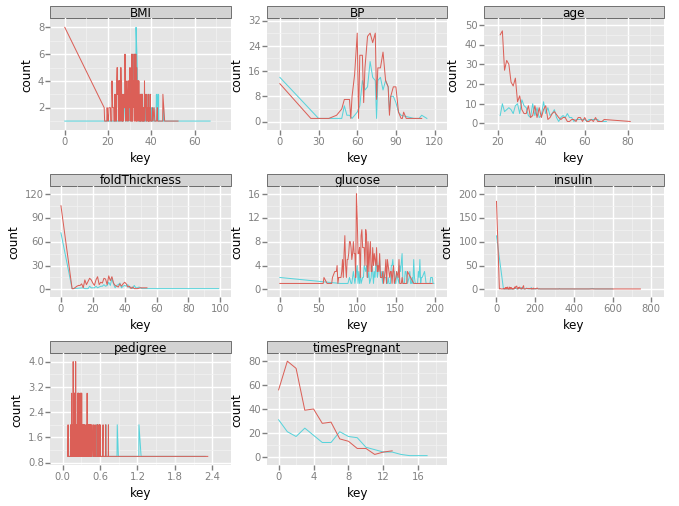

<ggplot: (288603653)>

In [118]:
# Plot Distribution of Features
freqColumns = ["feature", "category", "key","count"]
dfFreq = pd.DataFrame([], columns=freqColumns)

pdTrain = pd.DataFrame(trainData, columns=DATA_COLUMNS)
pdTrain['category'] = pd.Series(trainLabels, index=pdTrain.index)

for c, col in enumerate(DATA_COLUMNS):
    freq = [[col, k[0], k[1], v] for k,v in pdTrain.groupby("category")[col].value_counts().iteritems()]
    dfColFreq = pd.DataFrame(freq, columns=freqColumns)
    dfFreq = dfFreq.append(dfColFreq)   

p = ggplot(aes(x="key",y="count", group="category",colour="category"), data=dfFreq) + geom_line()
p + facet_wrap("feature")


In [150]:
# Validate Model
testMatrix = np.matrix(testData)
predictions = []
scores = []
for idx in xrange(testMatrix.shape[0]):
    bestEstimate = {'score':0.0, 'category':None}
    tmp = []
    for label, estimator in nbc.items():
        estimate = priors[label] * estimator.distribution.pdf(trainMatrix[idx,:])        
        tmp.append((label, estimate))
        if estimate >= bestEstimate['score']:
            bestEstimate = {'score': estimate, 'category': label}    
    scores.append(tmp)
    predictions.append(bestEstimate['category'])

computeConfusionMatrix(testLabels, predictions)

   Actual  Predicted   0
0       0          0  59
1       0          1  42
2       1          0  41
3       1          1  12
Accurarcy:  0.461038961039


1

In [120]:
# Using SciKit library for naive bayes 
from sklearn import datasets
iris = datasets.load_iris()
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
model = gnb.fit(trainData, trainLabels)
print model


GaussianNB()


In [122]:
y_pred = model.predict(testData)
computeConfusionMatrix(testLabels, y_pred)

   Actual  Predicted   0
0       0          0  82
1       0          1  19
2       1          0  25
3       1          1  28
Accurarcy:  0.714285714286


In [157]:
idx = 3

print "Expected "
print model.predict_proba(testData[idx])
print model.predict(testData[3])


print "Actual"
print scores[idx]
print predictions[idx]


print "Recomputed: "
values = []
for label, estimator in nbc.items():
    value = priors[label] * estimator.distribution.pdf(testMatrix[idx,:])
    print label, value
    values.append(value)
print np.array(values)/sum(values)

Expected 
[[ 0.74133604  0.25866396]]
[0]
Actual
[(0, 6.186754239637929e-16), (1, 9.8932020367344002e-15)]
1
Recomputed: 
0 3.24522831132e-14
1 1.12416799178e-14
[ 0.74271778  0.25728222]


/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


# Classification Using MultiAttribute Gaussian Distribution

In [100]:
# Train Model
model = defaultdict(GaussianEstimator)
priors = defaultdict(float)
numRows = len(trainData)
trainMatrix = np.matrix(trainData)
for idx in xrange(numRows):
    label = trainLabels[idx]
    model[label].add(trainMatrix[idx,:], 1.0)
    priors[label] += 1.0
    
priors = dict([(label, value/numRows) for label, value in priors.items()])
print "Priors: ", priors
    
for label, estimator in model.items():
    print "========== {0} =========".format(label)
    distribution = estimator.distribution    
    print "Mean: ", 
    print pd.DataFrame(distribution.mean)
    print "Variance: "
    print pd.DataFrame(distribution.variance)
    


Priors:  {0: 0.6498371335504886, 1: 0.3501628664495114}
========== 0 =========
Mean:           0           1          2          3          4          5         6  \
0  3.24812  109.829574  68.566416  19.827068  69.380952  30.171429  0.431193   

           7  
0  30.967419  
Variance: 
           0           1           2           3             4           5  \
0   8.538784    7.449428    8.155590   -3.125326    -26.554559    0.072434   
1   7.449428  633.850279  104.124413   19.269449    974.311318   30.909691   
2   8.155590  104.124413  277.763794   43.643424    115.864082   48.442857   
3  -3.125326   19.269449   43.643424  209.650924    605.312276   46.886253   
4 -26.554559  974.311318  115.864082  605.312276  10121.517827  214.437042   
5   0.072434   30.909691   48.442857   46.886253    214.437042   58.588629   
6  -0.044819    0.727608    0.180845    0.388719      7.861929    0.156197   
7  19.493029   66.532122   51.043627  -23.244342   -120.693587    4.094293   

         

In [103]:
# Validate Model
testMatrix = np.matrix(testData)
predictions = []

for idx in xrange(testMatrix.shape[0]):
    bestEstimate = {'score':0.0, 'category':None}
    for label, estimator in model.items():
        estimate = priors[label] * estimator.distribution.pdf(trainMatrix[idx,:])
        if estimate > bestEstimate['score']:
            bestEstimate = {'score': estimate, 'category': label}    
    predictions.append(bestEstimate['category'])

computeConfusionMatrix(testLabels, predictions)
    

   Actual  Predicted   0
0       0          0  68
1       0          1  33
2       1          0  41
3       1          1  12
Accurarcy:  0.519480519481


## Using Expectation Maximization

In [109]:
# Train Model
model = defaultdict(GaussianMixtureModelEstimator)
priors = defaultdict(float)
numRows = len(trainData)
trainMatrix = np.matrix(trainData)
for idx in xrange(numRows):
    label = trainLabels[idx]
    model[label].add(trainMatrix[idx,:], 1.0)
    priors[label] += 1.0
    
priors = dict([(label, value/numRows) for label, value in priors.items()])
print "Priors: ", priors
    
for label, estimator in model.items():
    print "========== {0} =========".format(label)
    mm = estimator.distribution(2, maxIter = 150, epsilon=0.001)
    for distribution in mm.distributions:
        print distribution


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:105: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Priors:  {0: 0.6498371335504886, 1: 0.3501628664495114}
========== 0 =========
Random Initialization
Mixing Coefficients: [0.5, 0.5]
Distribution 0:
--------------------

Mean: 
            0
0    4.168209
1   16.256653
2   19.777708
3   32.651099
4  403.085429
5   28.319398
6    1.117168
7   32.760552
Variance: 
     0     1     2     3      4      5       6     7
0  6.5   0.0   0.0   0.0    0.0   0.00  0.0000   0.0
1  0.0  98.5   0.0   0.0    0.0   0.00  0.0000   0.0
2  0.0   0.0  55.0   0.0    0.0   0.00  0.0000   0.0
3  0.0   0.0   0.0  27.0    0.0   0.00  0.0000   0.0
4  0.0   0.0   0.0   0.0  372.0   0.00  0.0000   0.0
5  0.0   0.0   0.0   0.0    0.0  26.15  0.0000   0.0
6  0.0   0.0   0.0   0.0    0.0   0.00  1.1255   0.0
7  0.0   0.0   0.0   0.0    0.0   0.00  0.0000  30.0
        
            
Distribution 1:
--------------------

Mean: 
            0
0    9.595815
1   43.725407
2   31.307079
3   26.923127
4  296.805397
5   26.823383
6    0.397732
7   51.159963
Variance: 
    

AssertionError: Covariance matrix is not positive definite : [[  3.76880514e+000   1.50753499e+001   2.22507386e-308   4.25009063e+000
    4.23438090e+001   2.22507386e-308   7.05353654e-001   9.54215042e+000]
 [  1.50753499e+001   3.79449832e+002   9.14437588e+000   2.22507386e-308
    1.89390277e+003   2.22507386e-308   1.22034618e+001   5.05951067e+001]
 [  2.22507386e-308   9.14437588e+000   1.03283360e+002   2.22507386e-308
    1.82838670e+002   3.22768563e+001   2.22507386e-308   8.17686330e+000]
 [  4.25009063e+000   2.22507386e-308   2.22507386e-308   1.41971253e+001
    2.22507386e-308   2.22507386e-308   2.22507386e-308   7.49451656e+000]
 [  4.23438090e+001   1.89390277e+003   1.82838670e+002   2.22507386e-308
    1.14133231e+004   1.09536544e+002   5.07102303e+001   2.02661456e+002]
 [  2.22507386e-308   2.22507386e-308   3.22768563e+001   2.22507386e-308
    1.09536544e+002   2.97745097e+001   2.22507386e-308   2.22507386e-308]
 [  7.05353654e-001   1.22034618e+001   2.22507386e-308   2.22507386e-308
    5.07102303e+001   2.22507386e-308   5.05421702e-001   1.75075780e+000]
 [  9.54215042e+000   5.05951067e+001   8.17686330e+000   7.49451656e+000
    2.02661456e+002   2.22507386e-308   1.75075780e+000   2.63036417e+001]], [[   2.19996661  161.79917798   77.59937346   39.79916806  586.77471436
    41.79958615    0.9194644    26.4006256 ]], [[   1.     100.      72.      12.      70.      25.3      0.658   28.   ]]

# Step 1: Randomly initialize mixing coefficients, mean and variance

==== KNOWN DISTRIBUTIONS ===
Mean: [60, 140] & [70, 170]


# References:

* Computing Variance in a streaming fashion: http://www.johndcook.com/blog/standard_deviation/


In [37]:
[1] + [2,3]

[1, 2, 3]

In [75]:
x = [
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1],
    [1, 1],
    [1, 1]
]
y = pd.DataFrame(x, columns=["Actual", "Predicted"])
z = y.groupby(["Actual","Predicted"]).size()
print z
print z[1,1]
print z.sum()

Actual  Predicted
0       0            1
        1            1
1       0            1
        1            3
dtype: int64
3
6


In [64]:
print z

Empty DataFrame
Columns: []
Index: [(0, 0), (0, 1), (1, 0), (1, 1)]
